In [1]:
!pip install -q kaggle

In [15]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100% 609M/612M [00:14<00:00, 51.9MB/s]
100% 612M/612M [00:14<00:00, 43.2MB/s]


In [17]:
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [18]:
import cv2
import numpy as np
import torch, torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as T

from pylab import rcParams

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import os
import shutil
from glob import glob
from pathlib import Path

%matplotlib inline
rcParams['figure.figsize'] = 12, 8

In [19]:
train_folders = sorted(glob('./Train/*'))
print(len(train_folders))
print(train_folders)

43
['./Train/0', './Train/1', './Train/10', './Train/11', './Train/12', './Train/13', './Train/14', './Train/15', './Train/16', './Train/17', './Train/18', './Train/19', './Train/2', './Train/20', './Train/21', './Train/22', './Train/23', './Train/24', './Train/25', './Train/26', './Train/27', './Train/28', './Train/29', './Train/3', './Train/30', './Train/31', './Train/32', './Train/33', './Train/34', './Train/35', './Train/36', './Train/37', './Train/38', './Train/39', './Train/4', './Train/40', './Train/41', './Train/42', './Train/5', './Train/6', './Train/7', './Train/8', './Train/9']


### Exploration

<ipython-input-20-853a0eae8519>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  images = torch.as_tensor(images)


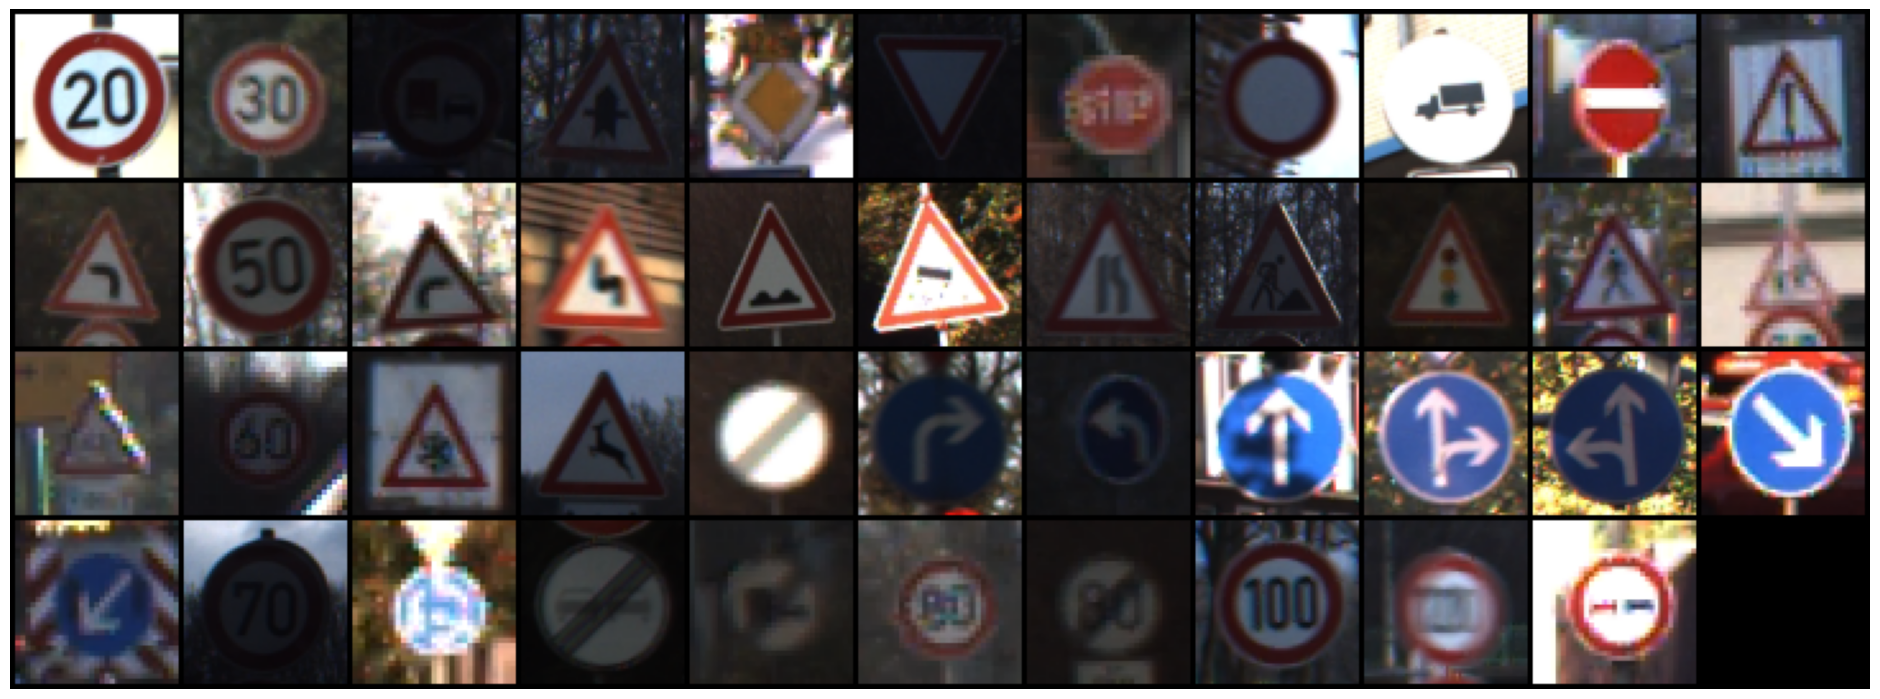

In [20]:
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
    return img

def show_sign_grid(image_paths):
    images = []
    for img in image_paths:
        images.append(load_image(img))
    images = torch.as_tensor(images)
    images = images.permute(0, 3, 1, 2)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24, 12))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off');

sample_image_paths = []
for tf in train_folders:
    sample_image_paths.append(np.random.choice(glob(f'{tf}/*.png')))

show_sign_grid(sample_image_paths)


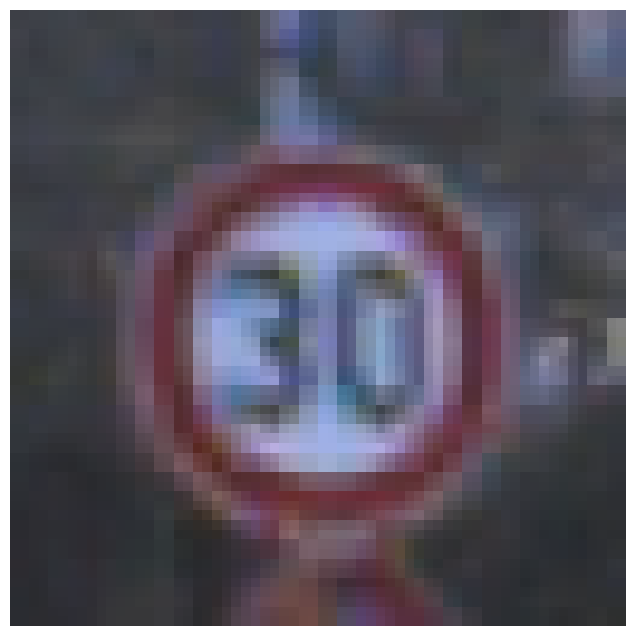

In [21]:
def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')

show_image(glob(f'{train_folders[1]}/*.png')[1])

In [22]:
# class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
# class_indices = [4, 5, 6, 9] # The order of the folders is messed. So manually finding indices
class_names=['0twenty_speed_limit', '1thirty_speed_limit', '10no-overtaking',
             '11crossroad', '12priority_road', '13yield', '14stop', '15no_vehicle',
             '16overload_vehicles_prohibited', '17do_not_enter', '18general_danger',
             '19left_curve', '2fifty_speed_limit', '20right_curve', '21double_curve',
             '22uneven_road_surface', '23slippery', '24road_narrows', '25road_works',
             '26traffic_signal_ahead', '27pedestrains', '28watch_for_children',
             '29bicycle_prohibited', '3sixty_speed_limit', '30ice_snow', '31wild_animal_crossing',
             '32end_of_restrictions', '33turn_right_ahead', '34turn_left_ahead',
             '35ahead_only', '36ahead_or_right_turn_only', '37ahead_or_left_turn_only',
             '38pass_by_on_right', '39pass_by_on_left', '4seventy_speed_limit', '40roundabout',
             '41end_of_no_passing_zone', '42end_of_no_passing_zone_for_trucks', '5eighty_speed_limit',
             '6end_of_speed_limit', '7hundred_speed_limit', '8one_twenty_speed_limit', '9no_passing']
# class_indices = ['0', '1','10','11','12','13','14','15','16','17','18','19','2','20','21','22','23','24','25','26','27','28','29','3','30','31','32','33','34','35','36','37','38','39','4','40','41','42','5','6','7','8','9']
class_indices = [i for i in range(43)]

In [23]:
len(class_names)

43

In [24]:
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

Reserving 80% of the images for training, 10% for validation, and 10% for test for each class

In [25]:
local_pc = False

for i, cls_index in enumerate(class_indices):
    if local_pc:
        image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))[:100]
    else:
        image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)

    ds_split = np.split(
        image_paths,
        indices_or_sections=[int(.8*len(image_paths)),int(.9*len(image_paths))]
    )

    dataset_data = zip(DATASETS, ds_split)

    for ds, images in dataset_data:
        for image_path in images:
            shutil.copy(image_path, f'{DATA_DIR}/{ds}/{class_name}/')

0twenty_speed_limit: 210
1thirty_speed_limit: 2220
10no-overtaking: 2010
11crossroad: 1320
12priority_road: 2100
13yield: 2160
14stop: 780
15no_vehicle: 630
16overload_vehicles_prohibited: 420
17do_not_enter: 1110
18general_danger: 1200
19left_curve: 210
2fifty_speed_limit: 2250
20right_curve: 360
21double_curve: 330
22uneven_road_surface: 390
23slippery: 510
24road_narrows: 270
25road_works: 1500
26traffic_signal_ahead: 600
27pedestrains: 240
28watch_for_children: 540
29bicycle_prohibited: 270
3sixty_speed_limit: 1410
30ice_snow: 450
31wild_animal_crossing: 780
32end_of_restrictions: 240
33turn_right_ahead: 689
34turn_left_ahead: 420
35ahead_only: 1200
36ahead_or_right_turn_only: 390
37ahead_or_left_turn_only: 210
38pass_by_on_right: 2070
39pass_by_on_left: 300
4seventy_speed_limit: 1980
40roundabout: 360
41end_of_no_passing_zone: 240
42end_of_no_passing_zone_for_trucks: 240
5eighty_speed_limit: 1860
6end_of_speed_limit: 420
7hundred_speed_limit: 1440
8one_twenty_speed_limit: 1410
9no

### Applying Image augmentation technique to artificially increase the size of our training dataset

In [26]:
# Mean and Standard deviation for Normalization. The following are the
# mean and standard deviation of the pixel values in the ImageNet dataset.

# Normalization is done here to speed up the convergence of the
# training process and to ensure that the model training remains stable.

mean_nums = [0.485,0.456,0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size=256),
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
])}

In [27]:
# Create a Pytorch dataset for each image dataset folder and data loaders
# for easier trainig.

image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) for d in DATASETS
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [28]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
print(dataset_sizes)
class_names = image_datasets['train'].classes
print(class_names)

{'train': 31367, 'val': 3921, 'test': 3921}
['0twenty_speed_limit', '10no-overtaking', '11crossroad', '12priority_road', '13yield', '14stop', '15no_vehicle', '16overload_vehicles_prohibited', '17do_not_enter', '18general_danger', '19left_curve', '1thirty_speed_limit', '20right_curve', '21double_curve', '22uneven_road_surface', '23slippery', '24road_narrows', '25road_works', '26traffic_signal_ahead', '27pedestrains', '28watch_for_children', '29bicycle_prohibited', '2fifty_speed_limit', '30ice_snow', '31wild_animal_crossing', '32end_of_restrictions', '33turn_right_ahead', '34turn_left_ahead', '35ahead_only', '36ahead_or_right_turn_only', '37ahead_or_left_turn_only', '38pass_by_on_right', '39pass_by_on_left', '3sixty_speed_limit', '40roundabout', '41end_of_no_passing_zone', '42end_of_no_passing_zone_for_trucks', '4seventy_speed_limit', '5eighty_speed_limit', '6end_of_speed_limit', '7hundred_speed_limit', '8one_twenty_speed_limit', '9no_passing']


### Using a pre-trained model

In [29]:
import time
from tqdm import tqdm
from collections import defaultdict

from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
def create_model(n_classes):
    model = models.resnet34(pretrained=True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)
    return model.to(device)

base_model = create_model(len(class_names))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 102MB/s]


In [31]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    progress = tqdm(data_loader, desc="Training", leave=False)
    for inputs, labels in progress:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar
        progress.set_postfix(loss=np.mean(losses), accuracy=correct_predictions.double() / n_examples)


    scheduler.step()
    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    progress = tqdm(data_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for inputs, labels in progress:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            # Update progress bar
            progress.set_postfix(loss=np.mean(losses), accuracy=correct_predictions.double() / n_examples)

    return correct_predictions.double() / n_examples, np.mean(losses)



def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)

    history = defaultdict(list)
    best_accuracy = 0

    # Record the start time of training
    total_start_time = time.time()

    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        print(f'Epoch {epoch + 1}/{n_epochs}')

        train_acc, train_loss = train_epoch(
            model,
            data_loaders['train'],
            loss_fn,
            optimizer,
            device,
            scheduler,
            dataset_sizes['train']
        )
        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            model,
            data_loaders['val'],
            loss_fn,
            device,
            dataset_sizes['val']
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print('-----------')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

        # Calculate elapsed time for this epoch
        epoch_duration = time.time() - epoch_start_time
        total_elapsed_time = time.time() - total_start_time

        # Estimate remaining time
        estimated_total_time = total_elapsed_time / (epoch + 1) * n_epochs
        remaining_time = estimated_total_time - total_elapsed_time

        # Convert remaining time to minutes and seconds
        remaining_minutes, remaining_seconds = divmod(remaining_time, 60)
        print(f'Epoch duration: {epoch_duration:.2f} seconds')
        print(f'Estimated remaining time: {int(remaining_minutes)} minutes {int(remaining_seconds)} seconds')


    print(f'Best val accuracy: {best_accuracy}')
    model.load_state_dict(torch.load('best_model_state.bin'))
    return model, history

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3


Train loss 0.91931647703919 accuracy 0.741161092868301


Val   loss 0.1643943239925371 accuracy 0.9336903851058403
-----------
Epoch duration: 427.52 seconds
Estimated remaining time: 14 minutes 15 seconds
Epoch 2/3


Train loss 0.46788241288043547 accuracy 0.8572066184206331


Val   loss 0.08456291308316943 accuracy 0.9663351185921958
-----------
Epoch duration: 420.81 seconds
Estimated remaining time: 7 minutes 4 seconds
Epoch 3/3


Train loss 0.3837213329399189 accuracy 0.8819778748366116


Val   loss 0.08693972313274063 accuracy 0.9637847487885743
-----------
Epoch duration: 424.51 seconds
Estimated remaining time: 0 minutes 0 seconds
Best val accuracy: 0.9663351185921958


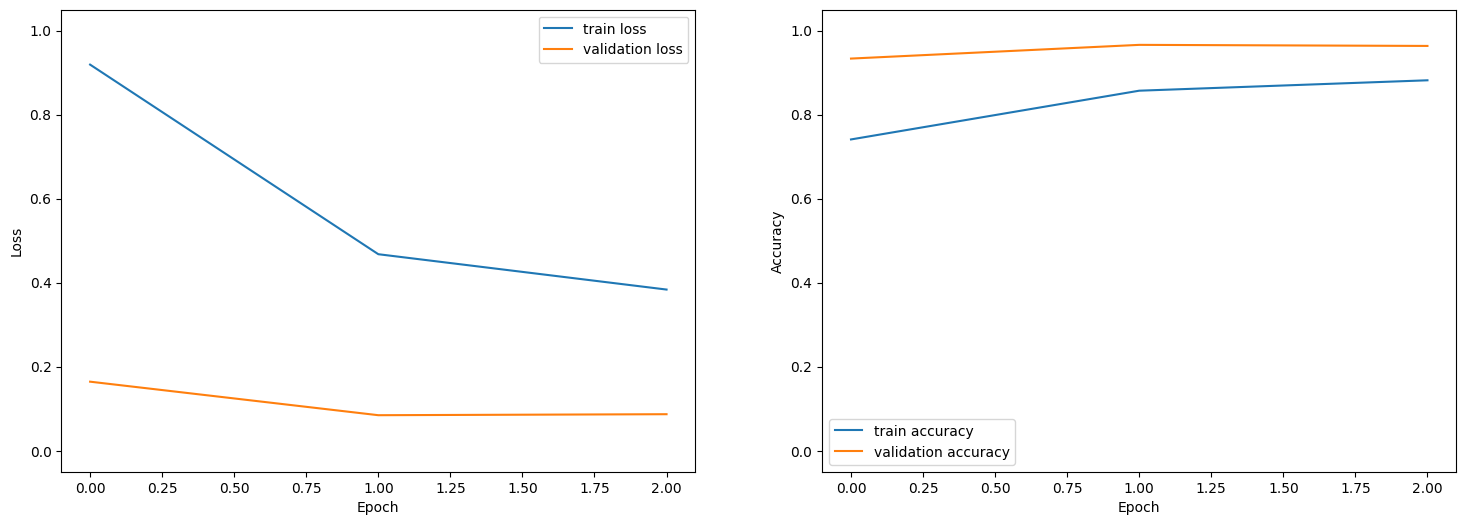

In [32]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Ensure history values are converted to CPU numpy arrays
    train_loss = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in history['train_loss']]
    val_loss = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in history['val_loss']]
    train_acc = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in history['train_acc']]
    val_acc = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in history['val_acc']]


    ax1.plot(train_loss, label='train loss')
    ax1.plot(val_loss, label='validation loss')
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(train_acc, label='train accuracy')
    ax2.plot(val_acc, label='validation accuracy')
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    plt.show()

plot_training_history(history)

In [35]:
from sklearn.metrics import classification_report

In [36]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values


y_pred, y_test = get_predictions(base_model, data_loaders['test'])
print(classification_report(y_test, y_pred, target_names=class_names))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


                                     precision    recall  f1-score   support

                0twenty_speed_limit       0.78      1.00      0.88        21
                    10no-overtaking       1.00      1.00      1.00       201
                        11crossroad       0.98      1.00      0.99       132
                    12priority_road       1.00      1.00      1.00       210
                            13yield       0.99      1.00      0.99       216
                             14stop       1.00      1.00      1.00        78
                       15no_vehicle       0.98      1.00      0.99        63
     16overload_vehicles_prohibited       1.00      1.00      1.00        42
                     17do_not_enter       1.00      1.00      1.00       111
                   18general_danger       1.00      1.00      1.00       120
                       19left_curve       0.47      0.81      0.60        21
                1thirty_speed_limit       1.00      0.98      0.99       22

In [38]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

In [41]:
import torch.nn.functional as F
import PIL.Image as Image

In [43]:
def predict_proba(model, image_path):
    image = Image.open(image_path)
    image = image.convert('RGB')
    image = transforms['test'](image).unsqueeze(0)

    pred = model(image.to(device))
    pred = F.softmax(pred, dim=1)
    return pred.detach().cpu().numpy().flatten()

pred = predict_proba(base_model, 'priority-road.jpeg')
pred

array([1.3151308e-05, 3.1466244e-03, 1.8876864e-05, 9.9439806e-01,
       5.0590030e-04, 7.4713862e-05, 3.4445504e-05, 8.2724364e-05,
       1.9161674e-04, 3.7875274e-05, 2.0388220e-06, 8.1768092e-05,
       2.8518589e-06, 5.6209665e-06, 3.5151621e-05, 9.2822411e-06,
       4.4556279e-07, 7.8306257e-05, 1.7832272e-04, 1.4629618e-06,
       1.1840743e-05, 5.2744199e-06, 7.9724690e-05, 2.0119207e-05,
       5.2827494e-05, 5.0223289e-06, 1.4595049e-05, 2.5763527e-05,
       3.8782338e-05, 1.3884284e-05, 7.2478651e-05, 7.7020428e-05,
       1.6428587e-05, 4.0482115e-05, 3.2600499e-05, 4.1119300e-05,
       2.8357397e-05, 1.3018560e-05, 1.9864929e-05, 2.5168886e-06,
       3.9964685e-05, 2.4206680e-05, 4.2479005e-04], dtype=float32)

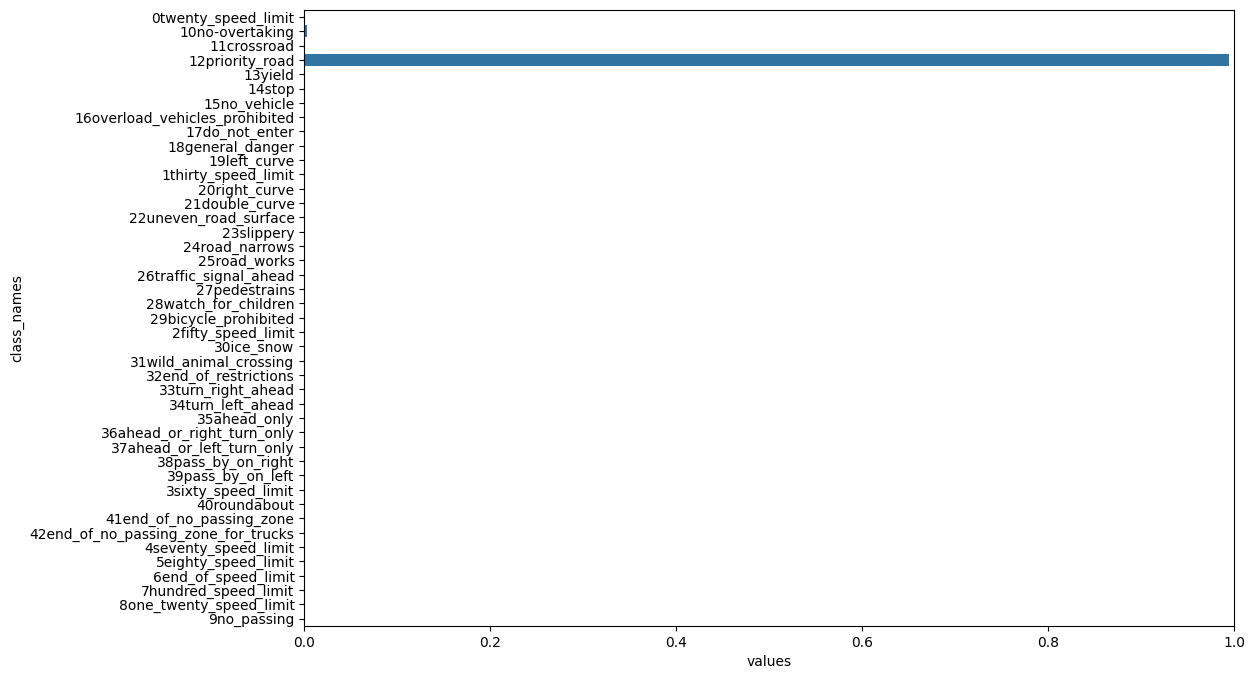

In [44]:
def show_prediction_confidence(prediction, class_names):
    pred_df = pd.DataFrame({
        'class_names': class_names,
        'values': prediction
    })
    sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
    plt.xlim([0, 1])

show_prediction_confidence(pred, class_names)